# Forecasts on data before COVID periods only

The purpose of this notebook is to compare the approach offered in the previous notebook to an approach that cuts off each time series at February 2020. That way, no COVID effects are present in any series. We consider using such forecasts into the future as their histories will be unaffected by the COVID periods and could lead to better performance in a post-COVID world. It also gives insight into which model types forecast these series' regular patterns most effectively.

In [1]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.notebook import results_vis
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from tqdm.notebook import tqdm as log_progress
from config import train_prop, metric, fcst_length

sns.set(rc={'figure.figsize':(14,7)})
series_map = pickle.load(open('pickled/series_map.pckl','rb'))
test_prop = 1 - train_prop
f_dict = {} # this is where the forecasts will be loaded

Create some helper objects for the Recurrent Neural Net models.

In [2]:
def create_rnn_args(epochs,lags,rnn_type,dropout=0):
    return dict(
        lags=lags,
        epochs=epochs,
        validation_split=.2,
        shuffle=True,
        hidden_layers_struct = {
            rnn_type:{'units':72,'dropout':dropout},
            rnn_type:{'units':72,'dropout':dropout},
            rnn_type:{'units':72,'dropout':dropout},
            rnn_type:{'units':72,'dropout':dropout},
        },
        verbose=0,
        plot_loss=False,
        random_seed=1 # this may help control some randomness
    )

In [3]:
rnn_map = {
    'IAH-Dom':{'lags':36,'epochs':30},
    'IAH-Int':{'lags':36,'epochs':10},
    'HOU-Dom':{'lags':36,'epochs':40},
    'HOU-Int':{'lags':6,'epochs':50},
}

Create the forecast function using scalecast lib.

In [4]:
def forecast(series,orders):
    #print(f'now forecasting {series}')
    df = pd.read_csv(os.path.join('data',series+'.csv'),parse_dates=['Date'])
    df = df.loc[df['Date'] < pd.Timestamp('2020-03-01')]
    f = Forecaster(df['PASSENGERS'],current_dates=df['Date'])
    f.set_test_length(test_prop)
    f.generate_future_dates(fcst_length)
    f.set_estimator('rnn')
    f.manual_forecast(**create_rnn_args(epochs=rnn_map[series]['epochs'],
                                        lags=rnn_map[series]['lags'],
                                        rnn_type='lstm',dropout=.2),
                      call_me='lstm_reg')
    f.manual_forecast(**create_rnn_args(epochs=rnn_map[series]['epochs'],
                                        lags=rnn_map[series]['lags'],
                                        rnn_type='lstm'),
                      call_me='lstm')
    f.set_estimator('arima')
    f.manual_forecast(order=orders['order'],seasonal_order=orders['seasonal_order'],trend=orders['trend'])
    f.set_estimator('prophet')
    f.manual_forecast()
    f.set_estimator('combo')
    f.manual_forecast(how='weighted',determine_best_by='TestSet'+metric,call_me='weighted_ensemble')
    results = f.export(determine_best_by='TestSet'+metric,to_excel=True,out_path='fcst_results',excel_name=f'no_covid_series_{series}_results.xlsx')
    results['model_summaries'][['ModelNickname','TestSet'+metric,'InSample'+metric]].set_index('ModelNickname').plot.bar()
    plt.xticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees
    plt.title(f'{series} all models train and test {metric}s',size=16)
    plt.show()
    print('='*120)
    return f

  0%|          | 0/4 [00:00<?, ?it/s]

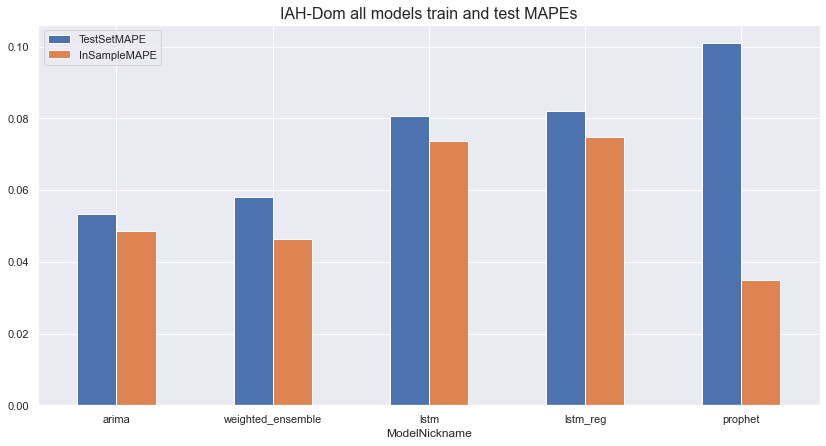

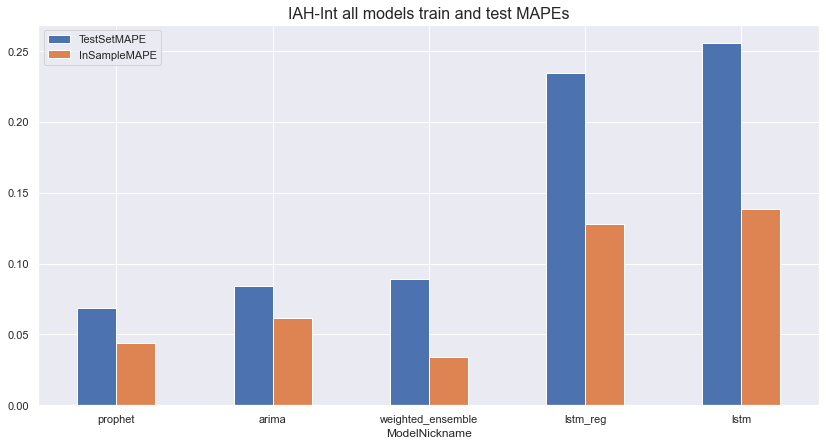

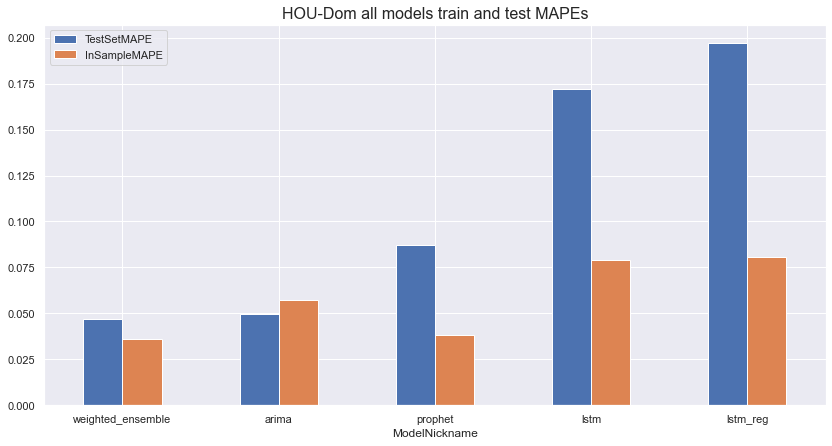

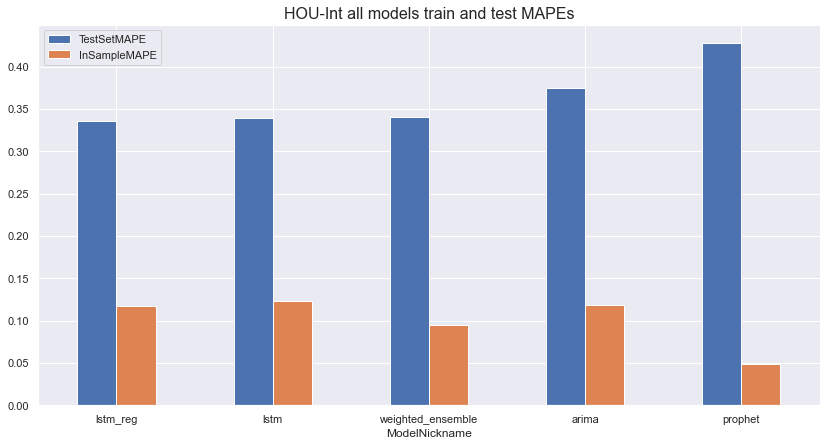

In [5]:
for series, orders in log_progress(series_map.items()):
    f_dict[series] = forecast(series,orders)

Visualize results on test set.

In [6]:
results_vis(f_dict,'test')

Dropdown(description='Time Series:', options=('IAH-Dom', 'IAH-Int', 'HOU-Dom', 'HOU-Int'), value='IAH-Dom')

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()

Visualize proposed forecasts to future.

In [7]:
results_vis(f_dict,'forecast',print_attr=['TestSet'+metric,'InSample'+metric])

Dropdown(description='Time Series:', options=('IAH-Dom', 'IAH-Int', 'HOU-Dom', 'HOU-Int'), value='IAH-Dom')

Dropdown(description='No. Models', options=(1, 2, 3, 4, 5), value=1)

Dropdown(description='View Level', options=(True, False), value=True)

Dropdown(description='View Confidence Intervals', options=(True, False), value=True)

Dropdown(description='Order By', options=('InSampleMAE', 'InSampleMAPE', 'InSampleR2', 'InSampleRMSE', 'LevelT…

Button(description='Select Time Series', style=ButtonStyle())

Output()